In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 12)
!date

%load_ext autoreload
%autoreload 2

Wed Sep 18 16:10:36 PDT 2019


# Table of SAM DALYs and delta SAM DALYs by scenario and by location and by CAUSE

In [2]:
%cd /share/costeffectiveness/results/vivarium_conic_sam_comparison

/ihme/costeffectiveness/results/vivarium_conic_sam_comparison


In [3]:
import glob
# sorted(glob.glob('*/*/output.hdf'))

In [4]:
location_list = ['India', 'Bangladesh', 'Pakistan', 'Tanzania', 'Malawi', 'Mali']
fname = {}
for loc in location_list:
    fname[loc] = sorted(glob.glob(f'vivarium_conic_sam_comparison_{loc}/*/output.hdf'))[-1]
fname

{'India': 'vivarium_conic_sam_comparison_India/2019_09_12_14_36_19/output.hdf',
 'Bangladesh': 'vivarium_conic_sam_comparison_Bangladesh/2019_09_12_16_06_24/output.hdf',
 'Pakistan': 'vivarium_conic_sam_comparison_Pakistan/2019_09_12_14_36_44/output.hdf',
 'Tanzania': 'vivarium_conic_sam_comparison_Tanzania/2019_09_12_14_36_50/output.hdf',
 'Malawi': 'vivarium_conic_sam_comparison_Malawi/2019_09_12_14_36_29/output.hdf',
 'Mali': 'vivarium_conic_sam_comparison_Mali/2019_09_12_14_36_37/output.hdf'}

In [5]:
df = {}
for loc in location_list:
    df[loc] = pd.read_hdf(fname[loc])
    print(loc, len(df[loc]))

India 4000
Bangladesh 4000
Pakistan 4000
Tanzania 4000
Malawi 4000
Mali 4000


In [6]:
for loc in location_list:
    del df[loc]['random_seed']

In [7]:
scenarios = ['interventions.BEP_intervention.coverage_proportion',
 'interventions.SQ_LNS_intervention.coverage_proportion',
 'interventions.TF_SAM_intervention.coverage_proportion',]

for loc in location_list:
    g = df[loc].reset_index().groupby(scenarios + ['input_draw_number'])
    print(f'{loc} has {len(g.groups)} groups, with {len(df[loc])/len(g.groups):.2f} reps per group')
    df[loc] = g.sum()


India has 400 groups, with 10.00 reps per group
Bangladesh has 400 groups, with 10.00 reps per group
Pakistan has 400 groups, with 10.00 reps per group
Tanzania has 400 groups, with 10.00 reps per group
Malawi has 400 groups, with 10.00 reps per group
Mali has 400 groups, with 10.00 reps per group


In [8]:
def scenario_map_generator():
    baseline = (0,0,0)
    bep = (.8, 0, 0)
    sqlns = (0, .8, 0)
    tfsam = (0, 0, .8)
    scenario_map = dict(baseline=baseline, bep=bep, sqlns=sqlns, tfsam=tfsam)

    return scenario_map
scenario_map = scenario_map_generator()

In [9]:
cause_list = ('lower_respiratory_infections diarrheal_diseases measles '
              + 'protein_energy_malnutrition ' +'other_causes '
              + 'neonatal_preterm_birth neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma '
              + 'hemolytic_disease_and_other_neonatal_jaundice '
              + 'neonatal_sepsis_and_other_neonatal_infections'
             ).split()

In [10]:
def dalys_per_100k(df, scenario, cause):
    
    scenario = scenario_map[scenario]
    
    # sam person years
    py = df.loc[scenario, 'person_time_in_child_stunting_cat1']
    dalys = pd.Series(0, index=py.index)
    for outcome in ['ylls', 'ylds']:
        if outcome == 'ylds' and cause == 'other_causes':
            continue # YLDs for other causes is not tracked
        key = f'{outcome}_due_to_{cause}_in_child_stunting_cat1'

        dalys += df.loc[scenario, key]
    
    return 100_000 * dalys / py
dalys_per_100k(df[loc], 'baseline', cause_list[0]).describe()

count       100.000000
mean     131466.945473
std       30835.639008
min       59704.377154
25%      109947.831165
50%      130331.702755
75%      151839.459151
max      241845.478735
dtype: float64

In [11]:
import pymc as pm

In [12]:
def my_formatted_output_pct(s):
    mu = f'{s.mean():.2f}'
    lb, ub = pm.utils.hpd(s, .05)
    lb = f'{lb:.2f}'
    ub = f'{ub:.2f}'
#     return [f'{mu} ({lb}, {ub})']
    return {'mean':mu, 'lb':lb, 'ub':ub}

In [13]:
def my_formatted_output_dalys(s):
    mu = f'{np.round(s.mean(), 2):.0f}'
    lb, ub = pm.utils.hpd(s, .05)
    lb = f'{np.round(lb, -2):.0f}'
    ub = f'{np.round(ub, -2):.0f}'
#     return [f'{mu} ({lb}, {ub})']
    return {'mean':mu}#, 'lb':lb, 'ub':ub}
my_formatted_output_dalys(dalys_per_100k(df[loc], 'baseline', cause_list[1]))

{'mean': '171412'}

In [14]:
results = {}

for loc in location_list:
    for cause in cause_list:
        val_0 = dalys_per_100k(df[loc], 'baseline', cause)
        for scenario in ['baseline', 'bep', 'sqlns', 'tfsam']:
            val_1 = dalys_per_100k(df[loc], scenario, cause)
            results[loc, cause, scenario, 'dalys'] = my_formatted_output_dalys(val_1)
            if scenario != 'baseline':
                results[loc, cause, scenario, 'dalys_averted'] = my_formatted_output_dalys(val_0-val_1)
                results[loc, cause, scenario, 'pct_averted'] = my_formatted_output_pct(100*(val_0-val_1)/val_0)
results = pd.DataFrame(results)        

In [15]:
results = results.T.unstack().unstack().dropna(axis=1, how='all')

In [16]:
pd.set_option('display.max_rows', len(cause_list)*2)

In [17]:
# col_to_sort = (0, 'pct', 'baseline')
col_to_sort = ('mean', 'dalys', 'baseline')
results.loc['India'].astype(float).sort_values(col_to_sort, ascending=False)

mean                    \
                                                      dalys                     
                                                   baseline      bep    sqlns   
diarrheal_diseases                                  59931.0  51156.0  58469.0   
lower_respiratory_infections                        49011.0  42701.0  47968.0   
neonatal_preterm_birth                              40113.0  40001.0  40106.0   
other_causes                                        38278.0  38191.0  38269.0   
protein_energy_malnutrition                         10158.0   9985.0  10109.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...   8026.0   7516.0   8024.0   
measles                                              3327.0   2940.0   3245.0   
neonatal_sepsis_and_other_neonatal_infections        2589.0   2435.0   2588.0   
hemolytic_disease_and_other_neonatal_jaundice        1872.0   1776.0   1871.0   

                                                                           \
                                                            dalys_averted   
                                                      tfsam           bep   
diarrheal_diseases                                  50692.0        8776.0   
lower_respiratory_infections                        42855.0        6309.0   
neonatal_preterm_birth                              39988.0         112.0   
other_causes                                        38181.0          87.0   
protein_energy_malnutrition                         10139.0         174.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...   8000.0         510.0   
measles                                              2797.0         387.0   
neonatal_sepsis_and_other_neonatal_infections        2584.0         154.0   
hemolytic_disease_and_other_neonatal_jaundice        1863.0          96.0   

                                                                    \
                                                                     
                                                     sqlns   tfsam   
diarrheal_diseases                                  1462.0  9239.0   
lower_respiratory_infections                        1043.0  6156.0   
neonatal_preterm_birth                                 7.0   125.0   
other_causes                                           8.0    97.0   
protein_energy_malnutrition                           49.0    20.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...     2.0    26.0   
measles                                               82.0   530.0   
neonatal_sepsis_and_other_neonatal_infections          1.0     5.0   
hemolytic_disease_and_other_neonatal_jaundice          1.0     9.0   

                                                                             \
                                                   pct_averted                
                                                           bep sqlns  tfsam   
diarrheal_diseases                                       14.64  2.44  15.42   
lower_respiratory_infections                             12.92  2.16  12.52   
neonatal_preterm_birth                                    0.28  0.02   0.31   
other_causes                                              0.23  0.02   0.25   
protein_energy_malnutrition                               1.74  0.50   0.20   
neonatal_encephalopathy_due_to_birth_asphyxia_a...        6.19  0.03   0.32   
measles                                                  10.86  2.17  14.86   
neonatal_sepsis_and_other_neonatal_infections             5.80 -0.04   0.17   
hemolytic_disease_and_other_neonatal_jaundice             3.76  0.03   0.77   

                                                            lb               \
                                                   pct_averted                
                                                           bep sqlns  tfsam   
diarrheal_diseases                                        9.67  0.04  10.72   
lower_respiratory_infections                       

In [18]:
results.loc['Bangladesh'].astype(float).sort_values(col_to_sort, ascending=False)

mean                    \
                                                      dalys                     
                                                   baseline      bep    sqlns   
lower_respiratory_infections                        56093.0  47520.0  54437.0   
other_causes                                        33663.0  33595.0  33651.0   
neonatal_preterm_birth                              28685.0  28616.0  28671.0   
diarrheal_diseases                                  20721.0  17133.0  20042.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...  13240.0  12443.0  13232.0   
protein_energy_malnutrition                         10941.0  10831.0  10894.0   
neonatal_sepsis_and_other_neonatal_infections        2198.0   2104.0   2197.0   
hemolytic_disease_and_other_neonatal_jaundice        2091.0   1944.0   2090.0   
measles                                               652.0    589.0    613.0   

                                                                           \
                                                            dalys_averted   
                                                      tfsam           bep   
lower_respiratory_infections                        48355.0        8573.0   
other_causes                                        33590.0          68.0   
neonatal_preterm_birth                              28608.0          70.0   
diarrheal_diseases                                  17141.0        3588.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...  13208.0         797.0   
protein_energy_malnutrition                         10933.0         109.0   
neonatal_sepsis_and_other_neonatal_infections        2192.0          95.0   
hemolytic_disease_and_other_neonatal_jaundice        2092.0         147.0   
measles                                               536.0          63.0   

                                                                    \
                                                                     
                                                     sqlns   tfsam   
lower_respiratory_infections                        1656.0  7738.0   
other_causes                                          13.0    73.0   
neonatal_preterm_birth                                15.0    78.0   
diarrheal_diseases                                   679.0  3580.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...     8.0    32.0   
protein_energy_malnutrition                           47.0     8.0   
neonatal_sepsis_and_other_neonatal_infections          1.0     6.0   
hemolytic_disease_and_other_neonatal_jaundice          1.0    -1.0   
measles                                               39.0   116.0   

                                                                             \
                                                   pct_averted                
                                                           bep sqlns  tfsam   
lower_respiratory_infections                             15.21  3.00  13.96   
other_causes                                              0.18  0.03   0.19   
neonatal_preterm_birth                                    0.24  0.05   0.27   
diarrheal_diseases                                       17.38  3.50  17.14   
neonatal_encephalopathy_due_to_birth_asphyxia_a...        5.99  0.06   0.24   
protein_energy_malnutrition                               1.22  0.47   0.04   
neonatal_sepsis_and_other_neonatal_infections             4.91  0.05   0.27   
hemolytic_disease_and_other_neonatal_jaundice             6.84  0.06   0.18   
measles                                                   8.96  6.30  14.83   

                                                            lb               \
                                                   pct_averted                
                                                           bep sqlns  tfsam   
lower_respiratory_infections                              8.01  0.05   7.27   
other_causes                                       

In [19]:
results.loc['Mali'].astype(float).sort_values(col_to_sort, ascending=False)

mean            \
                                                       dalys             
                                                    baseline       bep   
diarrheal_diseases                                  171412.0  147614.0   
other_causes                                        134307.0  134101.0   
lower_respiratory_infections                        131467.0  114730.0   
protein_energy_malnutrition                         110559.0  110358.0   
neonatal_preterm_birth                               73023.0   72431.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...   18177.0   17272.0   
measles                                              16990.0   14856.0   
neonatal_sepsis_and_other_neonatal_infections         8534.0    8135.0   
hemolytic_disease_and_other_neonatal_jaundice         2733.0    2636.0   

                                                                        \
                                                                         
                                                       sqlns     tfsam   
diarrheal_diseases                                  166194.0  142481.0   
other_causes                                        134209.0  133939.0   
lower_respiratory_infections                        127617.0  112590.0   
protein_energy_malnutrition                         110453.0  110254.0   
neonatal_preterm_birth                               72890.0   72312.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...   18150.0   18002.0   
measles                                              16335.0   13827.0   
neonatal_sepsis_and_other_neonatal_infections         8518.0    8468.0   
hemolytic_disease_and_other_neonatal_jaundice         2738.0    2718.0   

                                                                          \
                                                   dalys_averted           
                                                             bep   sqlns   
diarrheal_diseases                                       23798.0  5218.0   
other_causes                                               206.0    98.0   
lower_respiratory_infections                             16737.0  3850.0   
protein_energy_malnutrition                                200.0   106.0   
neonatal_preterm_birth                                     592.0   133.0   
neonatal_encephalopathy_due_to_birth_asphyxia_a...         906.0    28.0   
measles                                                   2134.0   656.0   
neonatal_sepsis_and_other_neonatal_infections              399.0    15.0   
hemolytic_disease_and_other_neonatal_jaundice               97.0    -5.0   

                                                                               \
                                                            pct_averted         
                                                      tfsam         bep sqlns   
diarrheal_diseases                                  28931.0       13.85  3.00   
other_causes                                          368.0        0.15  0.07   
lower_respiratory_infections                        18877.0       12.73  2.93   
protein_energy_malnutrition                           304.0        0.18  0.09   
neonatal_preterm_birth                                711.0        0.80  0.18   
neonatal_encephalopathy_due_to_birth_asphyxia_a...    175.0        5.20  0.16   
measles                                              3163.0       13.17  4.28   
neonatal_sepsis_and_other_neonatal_infections          66.0        4.60  0.18   
hemolytic_disease_and_other_neonatal_jaundice          15.0        3.11 -0.17   

                                                                   lb        \
                                                          pct_averted         
                                                    tfsam         bep sqlns   
diarrheal_diseases                                  16.82       10.27  1.43   
other_causes                                         0.28       -0.93 -0.26 

In [20]:
def cause_specific_dalys_by_location(cause):
    rows = [(location, cause) for location in location_list]
    return results.loc[rows, ('mean', 'dalys_averted')]
cause_specific_dalys_by_location('diarrheal_diseases')

,,bep,sqlns,tfsam
India,diarrheal_diseases,8776,1462,9239
Bangladesh,diarrheal_diseases,3588,679,3580
Pakistan,diarrheal_diseases,12392,2474,11867
Tanzania,diarrheal_diseases,14201,3288,16020
Malawi,diarrheal_diseases,12358,3066,13062
Mali,diarrheal_diseases,23798,5218,28931


In [21]:
cause_specific_dalys_by_location('lower_respiratory_infections')

,,bep,sqlns,tfsam
India,lower_respiratory_infections,6309,1043,6156
Bangladesh,lower_respiratory_infections,8573,1656,7738
Pakistan,lower_respiratory_infections,10820,2110,10124
Tanzania,lower_respiratory_infections,40493,6746,42826
Malawi,lower_respiratory_infections,27688,6052,29615
Mali,lower_respiratory_infections,16737,3850,18877


In [22]:
def cause_specific_pct_by_location(cause):
    rows = [(location, cause) for location in location_list]
    return results.loc[rows, ('mean', 'pct_averted')]
cause_specific_pct_by_location('diarrheal_diseases')

,,bep,sqlns,tfsam
India,diarrheal_diseases,14.64,2.44,15.42
Bangladesh,diarrheal_diseases,17.38,3.50,17.14
Pakistan,diarrheal_diseases,15.64,3.16,14.87
Tanzania,diarrheal_diseases,15.99,3.67,18.04
Malawi,diarrheal_diseases,12.63,3.13,13.34
Mali,diarrheal_diseases,13.85,3.00,16.82


In [23]:
cause_specific_pct_by_location('lower_respiratory_infections')

,,bep,sqlns,tfsam
India,lower_respiratory_infections,12.92,2.16,12.52
Bangladesh,lower_respiratory_infections,15.21,3.00,13.96
Pakistan,lower_respiratory_infections,15.52,3.06,14.75
Tanzania,lower_respiratory_infections,15.29,2.60,16.28
Malawi,lower_respiratory_infections,16.35,3.61,17.54
Mali,lower_respiratory_infections,12.73,2.93,14.36


In [24]:
cause_specific_pct_by_location('neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma')

,,bep,sqlns,tfsam
India,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,6.19,0.03,0.32
Bangladesh,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,5.99,0.06,0.24
Pakistan,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,5.64,0.05,0.44
Tanzania,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,2.33,0.01,0.94
Malawi,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,4.91,0.15,0.74
Mali,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,5.20,0.16,0.96


# Figures for presentation

In [25]:
import seaborn as sns
sns.set_context('talk', font_scale=1.5)

def set_plot_size():
    from IPython.core.pylabtools import figsize
    figsize(11, 5.5)
set_plot_size()

In [26]:
cause_list

['lower_respiratory_infections',
 'diarrheal_diseases',
 'measles',
 'protein_energy_malnutrition',
 'other_causes',
 'neonatal_preterm_birth',
 'neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma',
 'hemolytic_disease_and_other_neonatal_jaundice',
 'neonatal_sepsis_and_other_neonatal_infections']

In [27]:
def pretty_name(n):
    pretty_name_mapping = {'lower_respiratory_infections' : 'LRI',
             'diarrheal_diseases': 'Diarrhea',
             'measles': 'Measles',
             'protein_energy_malnutrition': 'PEM',
             'other_causes': 'Other',
             'neonatal_preterm_birth': 'Preterm',
             'neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma': 'Neonatal encephalopathy',
             'hemolytic_disease_and_other_neonatal_jaundice': 'Neonatal jaundice',
             'neonatal_sepsis_and_other_neonatal_infections': 'Neonatal sepsis'
                          }
    return pretty_name_mapping.get(n)

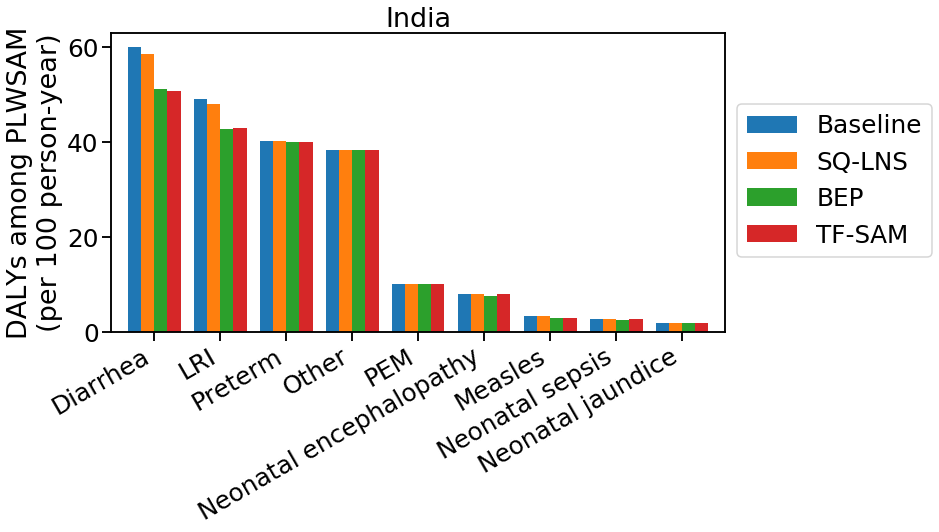

In [28]:
def my_plot(country, cols_to_blank=[]):
    t = (results.loc[country, ('mean', 'dalys')].astype(float)/1_000)\
        .filter(['baseline', 'sqlns', 'bep', 'tfsam'])
    t.loc[:, cols_to_blank] = 0
    
    t.columns = ['Baseline', 'SQ-LNS', 'BEP', 'TF-SAM']
    t = t.sort_values('Baseline', ascending=False)
    t.index = pd.Series(t.index).map(pretty_name)
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))

    plt.ylabel('DALYs among PLWSAM\n(per 100 person-year)')
    plt.xticks(rotation=30, ha='right')
    plt.title(country)
my_plot('India', cols_to_blank=[])

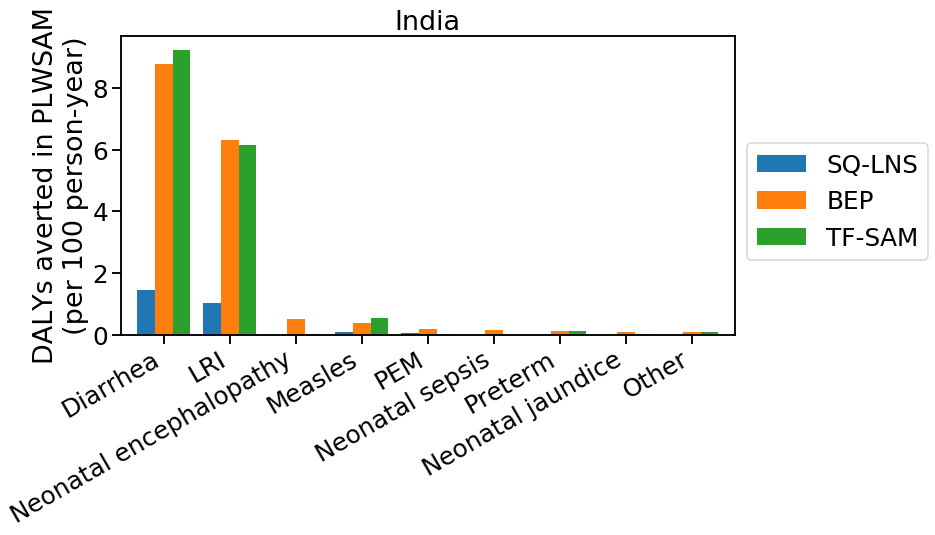

In [29]:
def my_plot(country, cols_to_blank=[]):
    t = (results.loc[country, ('mean', 'dalys_averted')].astype(float)/1_000)\
        .filter(['sqlns', 'bep', 'tfsam'])
    t.loc[:, cols_to_blank] = 0
    
    t.columns = ['SQ-LNS', 'BEP', 'TF-SAM']
    t = t.sort_values('BEP', ascending=False)
    t.index = pd.Series(t.index).map(pretty_name)
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))

    plt.ylabel('DALYs averted in PLWSAM\n(per 100 person-year)')
    plt.xticks(rotation=30, ha='right')
    plt.axis(ymin=0)
    plt.title(country)
my_plot('India', cols_to_blank=[])

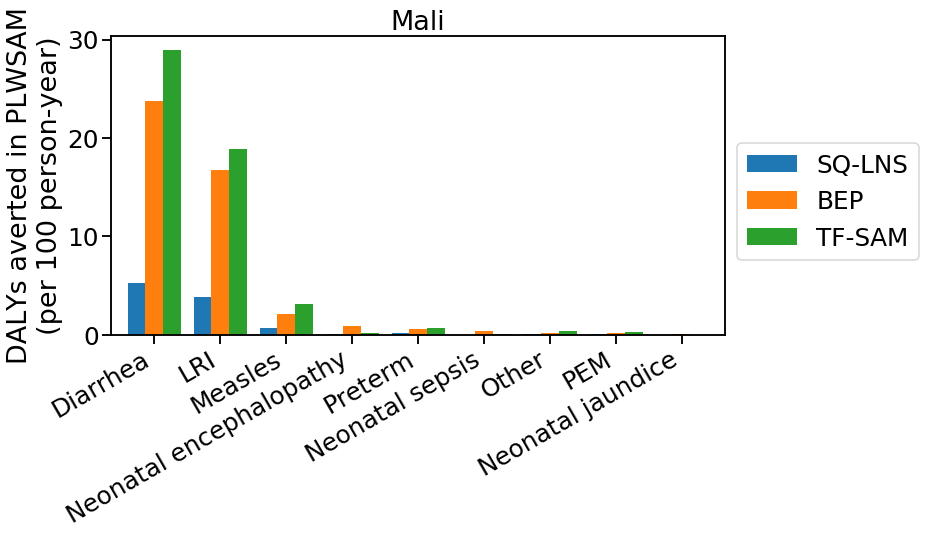

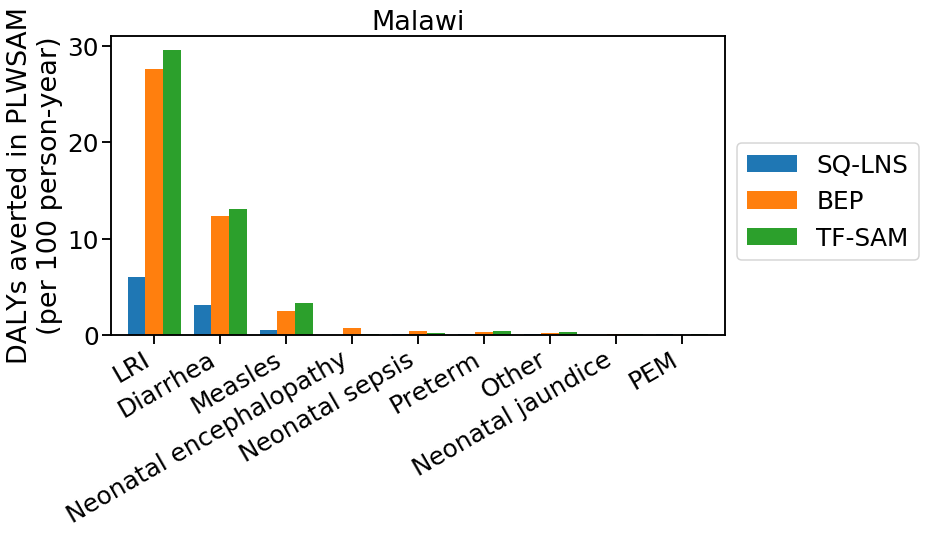

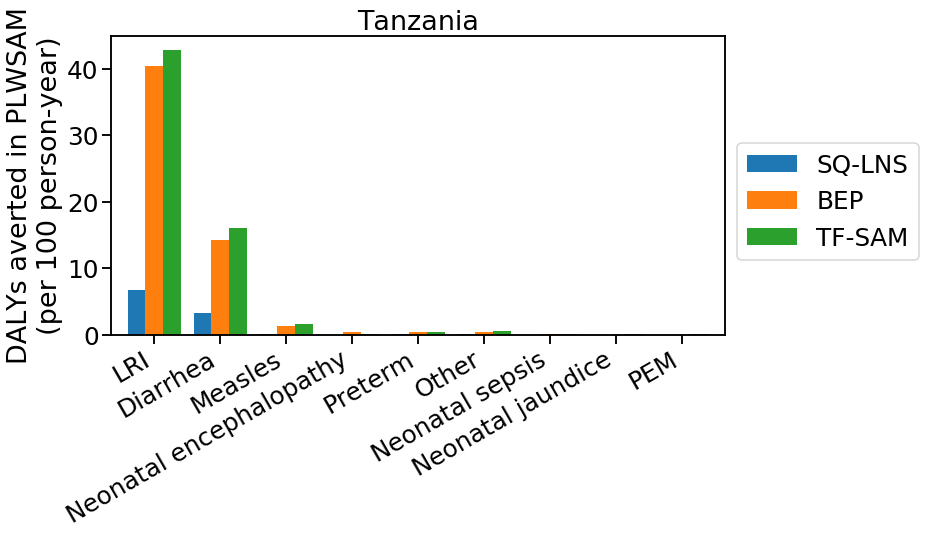

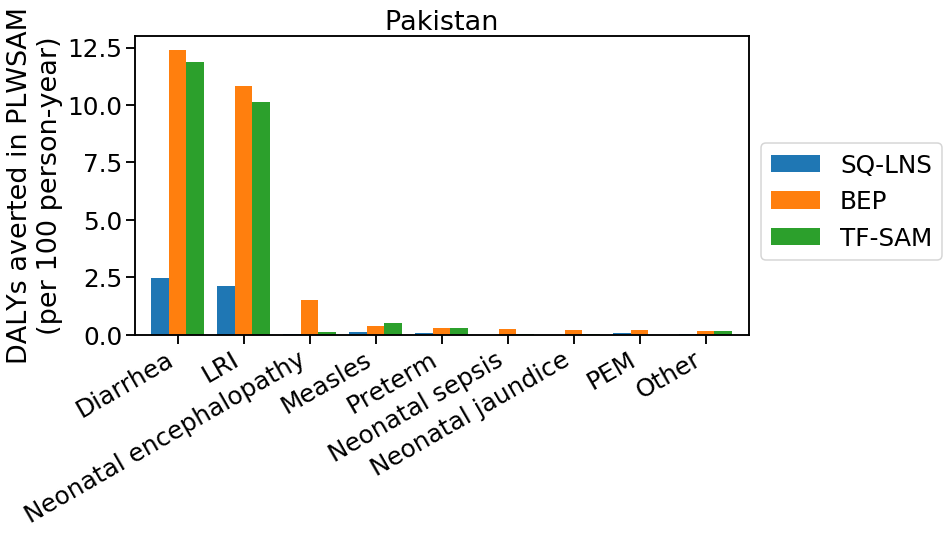

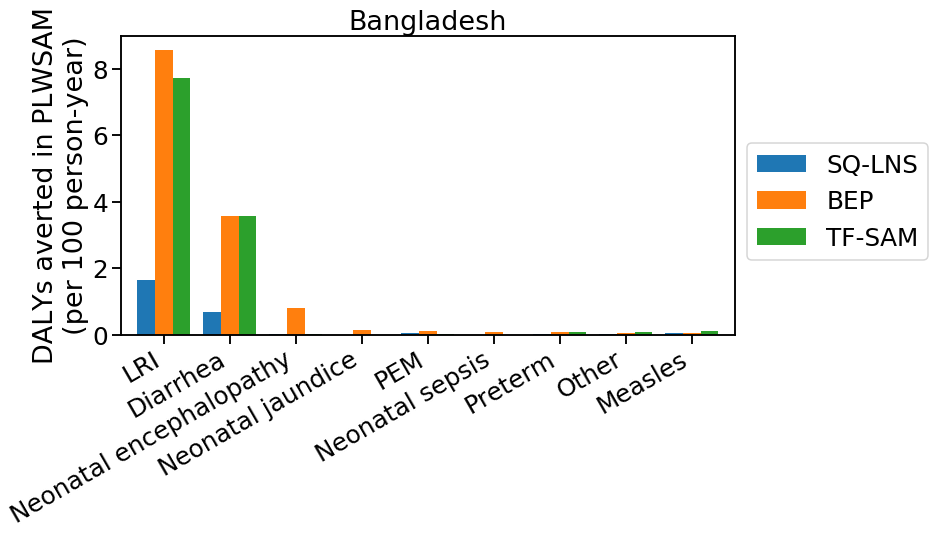

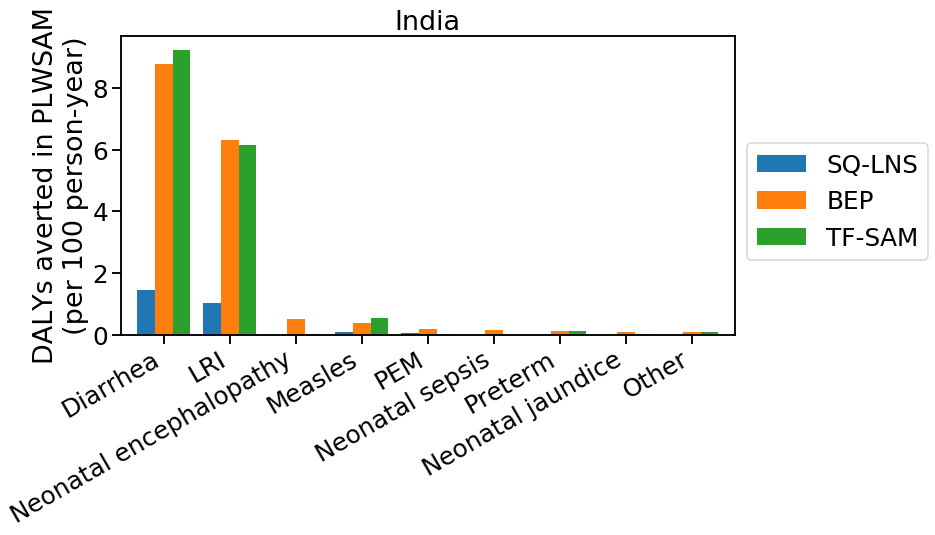

In [30]:
for location in location_list[::-1]:
    my_plot(location)

In [31]:
cause_specific_dalys_by_location('diarrheal_diseases')

,,bep,sqlns,tfsam
India,diarrheal_diseases,8776,1462,9239
Bangladesh,diarrheal_diseases,3588,679,3580
Pakistan,diarrheal_diseases,12392,2474,11867
Tanzania,diarrheal_diseases,14201,3288,16020
Malawi,diarrheal_diseases,12358,3066,13062
Mali,diarrheal_diseases,23798,5218,28931


In [32]:
cause_specific_dalys_by_location('lower_respiratory_infections')

,,bep,sqlns,tfsam
India,lower_respiratory_infections,6309,1043,6156
Bangladesh,lower_respiratory_infections,8573,1656,7738
Pakistan,lower_respiratory_infections,10820,2110,10124
Tanzania,lower_respiratory_infections,40493,6746,42826
Malawi,lower_respiratory_infections,27688,6052,29615
Mali,lower_respiratory_infections,16737,3850,18877


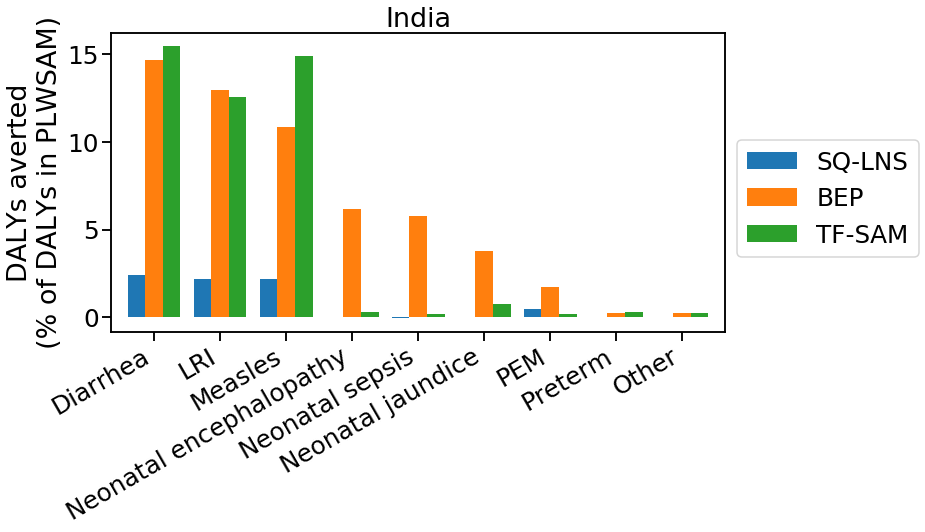

In [33]:
def my_plot(country, cols_to_blank=[]):
    t = (results.loc[country, ('mean', 'pct_averted')].astype(float))\
        .filter(['sqlns', 'bep', 'tfsam'])
    t.loc[:, cols_to_blank] = 0
    
    t.columns = ['SQ-LNS', 'BEP', 'TF-SAM']
    t = t.sort_values('BEP', ascending=False)
    t.index = pd.Series(t.index).map(pretty_name)
    t.plot.bar(width=.8)

    plt.legend(loc=(1.02, .25))

    plt.ylabel('DALYs averted\n(% of DALYs in PLWSAM)')
    plt.xticks(rotation=30, ha='right')
    plt.title(country)
my_plot('India', cols_to_blank=[])

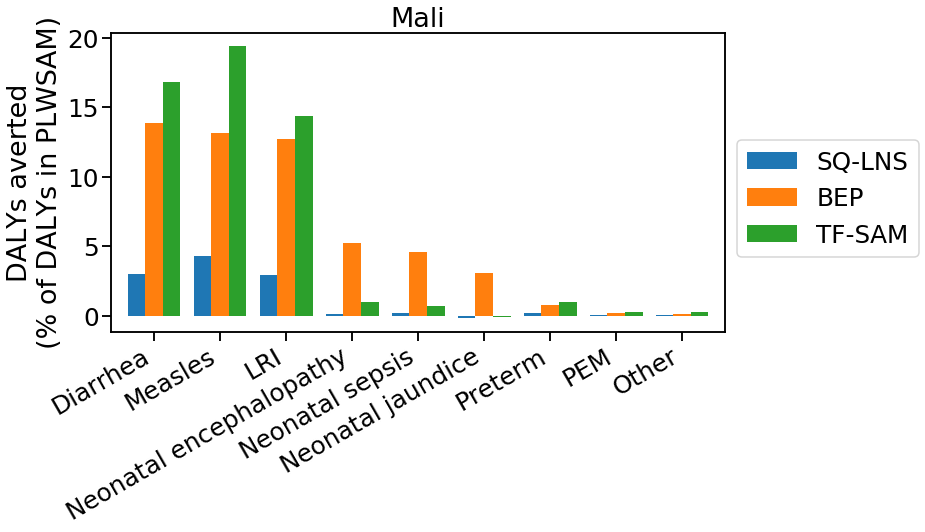

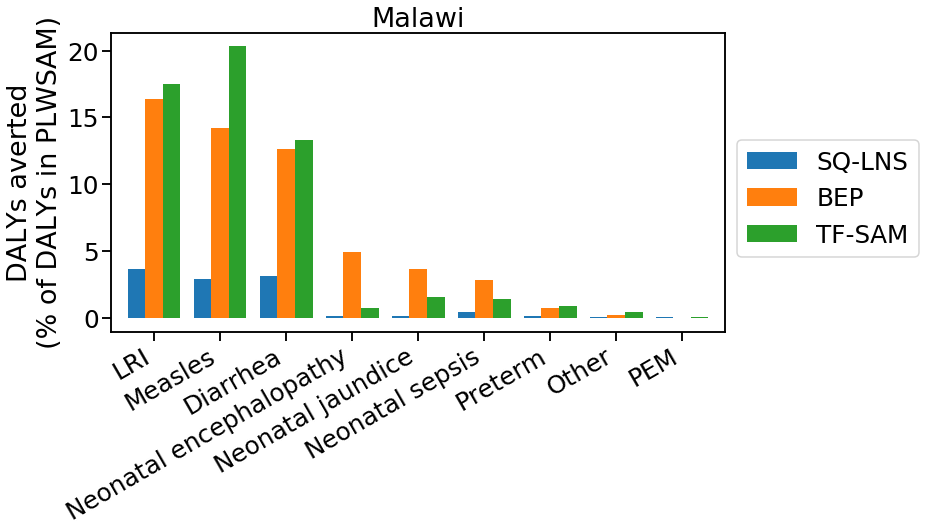

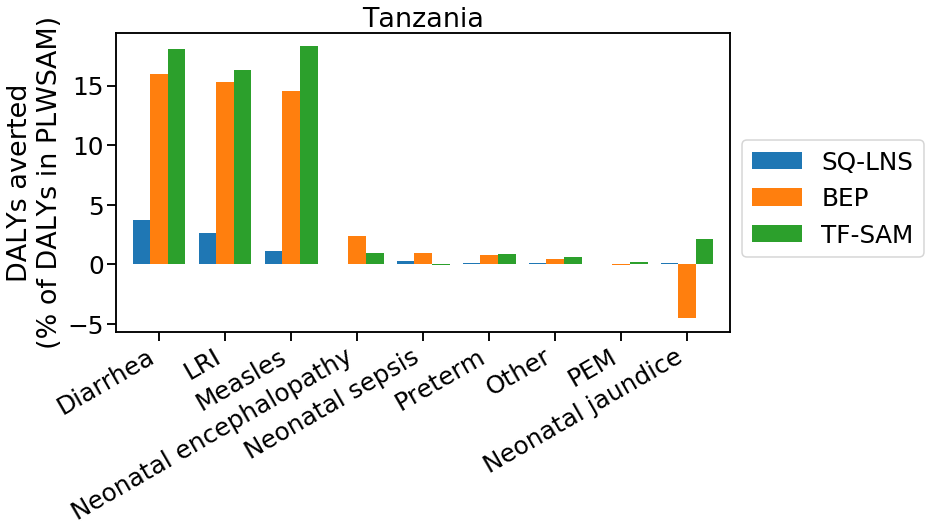

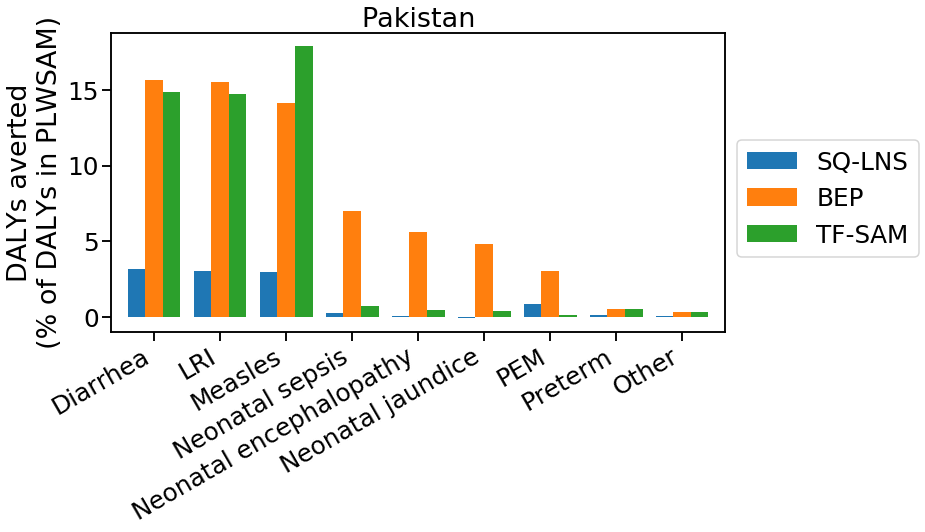

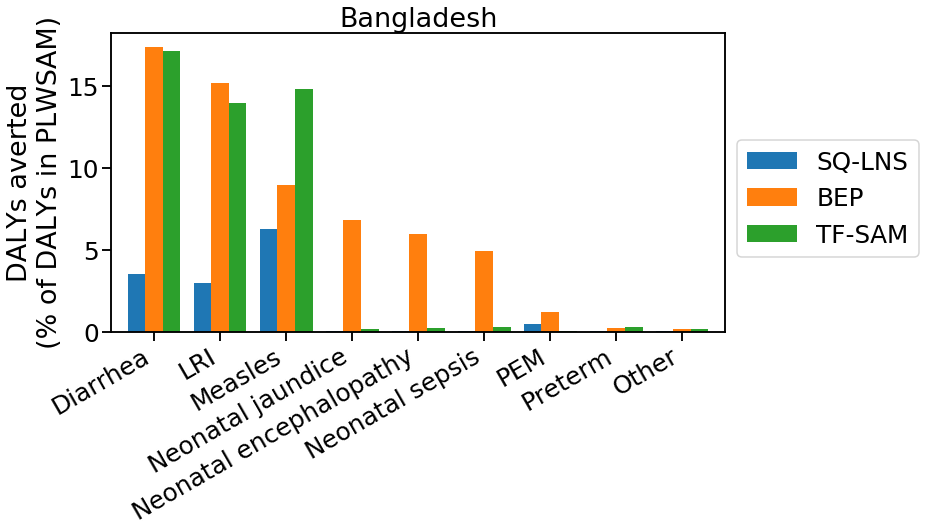

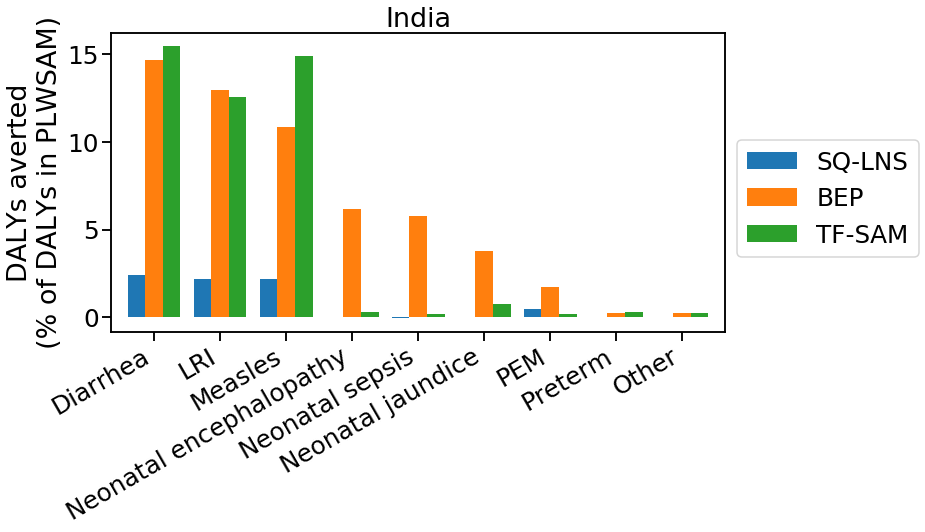

In [34]:
for location in location_list[::-1]:
    my_plot(location)

In [35]:
cause_specific_pct_by_location('diarrheal_diseases')

,,bep,sqlns,tfsam
India,diarrheal_diseases,14.64,2.44,15.42
Bangladesh,diarrheal_diseases,17.38,3.50,17.14
Pakistan,diarrheal_diseases,15.64,3.16,14.87
Tanzania,diarrheal_diseases,15.99,3.67,18.04
Malawi,diarrheal_diseases,12.63,3.13,13.34
Mali,diarrheal_diseases,13.85,3.00,16.82


In [36]:
cause_specific_pct_by_location('lower_respiratory_infections')

,,bep,sqlns,tfsam
India,lower_respiratory_infections,12.92,2.16,12.52
Bangladesh,lower_respiratory_infections,15.21,3.00,13.96
Pakistan,lower_respiratory_infections,15.52,3.06,14.75
Tanzania,lower_respiratory_infections,15.29,2.60,16.28
Malawi,lower_respiratory_infections,16.35,3.61,17.54
Mali,lower_respiratory_infections,12.73,2.93,14.36


In [37]:
cause_specific_pct_by_location('neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma')

,,bep,sqlns,tfsam
India,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,6.19,0.03,0.32
Bangladesh,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,5.99,0.06,0.24
Pakistan,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,5.64,0.05,0.44
Tanzania,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,2.33,0.01,0.94
Malawi,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,4.91,0.15,0.74
Mali,neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma,5.20,0.16,0.96


In [38]:
df['Pakistan'].filter(like='encepha').T

interventions.BEP_intervention.coverage_proportion              0.0  \
interventions.SQ_LNS_intervention.coverage_proportion           0.0   
interventions.TF_SAM_intervention.coverage_proportion           0.0   
input_draw_number                                             8.0     
death_due_to_neonatal_encephalopathy_due_to_bir...         0.000000   
ylls_due_to_neonatal_encephalopathy_due_to_birt...         0.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       625.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       135.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       306.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...        57.000000   
neonatal_encephalopathy_due_to_birth_asphyxia_a...      2231.000000   
susceptible_to_neonatal_encephalopathy_due_to_b...         0.000000   
neonatal_encephalopathy_due_to_birth_asphyxia_a...         0.000000   
ylds_due_to_neonatal_encephalopathy_due_to_birt...       145.701317   
ylds_due_to_neonatal_encephalopathy_due_to_birt...       171.883464   
ylds_due_to_neonatal_encephalopathy_due_to_birt...        81.422069   
ylds_due_to_neonatal_encephalopathy_due_to_birt...       164.026989   
ylds_due_to_neonatal_encephalopathy_due_to_birt...        18.752720   
ylls_due_to_neonatal_encephalopathy_due_to_birt...     54893.902857   
ylls_due_to_neonatal_encephalopathy_due_to_birt...     11860.823427   
ylls_due_to_neonatal_encephalopathy_due_to_birt...     26885.028646   
ylls_due_to_neonatal_encephalopathy_due_to_birt...      5008.273420   

interventions.BEP_intervention.coverage_proportion                   \
interventions.SQ_LNS_intervention.coverage_proportion                 
interventions.TF_SAM_intervention.coverage_proportion                 
input_draw_number                                             21.0    
death_due_to_neonatal_encephalopathy_due_to_bir...         0.000000   
ylls_due_to_neonatal_encephalopathy_due_to_birt...         0.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       613.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       111.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       199.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...        45.000000   
neonatal_encephalopathy_due_to_birth_asphyxia_a...      1663.000000   
susceptible_to_neonatal_encephalopathy_due_to_b...         0.000000   
neonatal_encephalopathy_due_to_birth_asphyxia_a...         0.000000   
ylds_due_to_neonatal_encephalopathy_due_to_birt...        76.957730   
ylds_due_to_neonatal_encephalopathy_due_to_birt...       273.900310   
ylds_due_to_neonatal_encephalopathy_due_to_birt...        89.084625   
ylds_due_to_neonatal_encephalopathy_due_to_birt...       112.177733   
ylds_due_to_neonatal_encephalopathy_due_to_birt...        15.492670   
ylls_due_to_neonatal_encephalopathy_due_to_birt...     53836.346582   
ylls_due_to_neonatal_encephalopathy_due_to_birt...      9753.293387   
ylls_due_to_neonatal_encephalopathy_due_to_birt...     17477.365605   
ylls_due_to_neonatal_encephalopathy_due_to_birt...      3954.416144   

interventions.BEP_intervention.coverage_proportion                   \
interventions.SQ_LNS_intervention.coverage_proportion                 
interventions.TF_SAM_intervention.coverage_proportion                 
input_draw_number                                             29.0    
death_due_to_neonatal_encephalopathy_due_to_bir...         0.000000   
ylls_due_to_neonatal_encephalopathy_due_to_birt...         0.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       609.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...        92.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...       191.000000   
death_due_to_neonatal_encephalopathy_due_to_bir...        53.000000   
neonatal_encephalopathy_due_to_birth_asphyxia_a...      1737.000000   
susceptible_to_neonatal_encephalopathy_due_to_b...         0.000000   
neonatal_encephalopath

In [39]:
country = 'India'
key = 'death_due_to_neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma_in_child_stunting_cat1'
t = df[country].loc[:,
    key].unstack().T
t # I expect the first three colunms to be the same

interventions.BEP_intervention.coverage_proportion      0.0               0.8
interventions.SQ_LNS_intervention.coverage_proportion   0.0         0.8   0.0
interventions.TF_SAM_intervention.coverage_proportion   0.0   0.8   0.0   0.0
input_draw_number                                                            
8.0                                                    25.0  25.0  25.0  26.0
21.0                                                   26.0  26.0  26.0  25.0
29.0                                                   28.0  28.0  28.0  28.0
30.0                                                   20.0  20.0  20.0  19.0
36.0                                                   33.0  33.0  33.0  33.0
...                                                     ...   ...   ...   ...
954.0                                                  28.0  28.0  28.0  27.0
956.0                                                  34.0  34.0  34.0  32.0
983.0                                                  17.0  17.0  17.0  15.0
990.0                                                  19.0  19.0  19.0  16.0
998.0                                                  24.0  24.0  24.0  22.0

[100 rows x 4 columns]

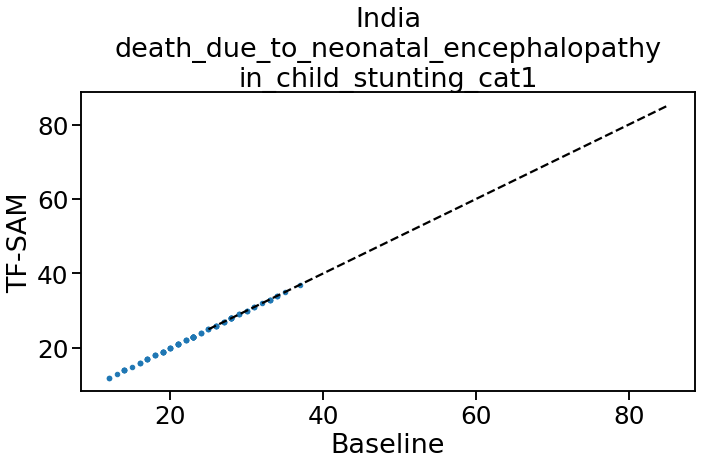

In [40]:
plt.plot(t.iloc[:,0], t.iloc[:,1], '.')
plt.plot([25,85], [25,85], 'k--')
plt.xlabel('Baseline')
plt.ylabel('TF-SAM')
pretty_key = key.replace('_due_to_birth_asphyxia_and_trauma_', '\n')
plt.title(f"{country}\n{pretty_key}");

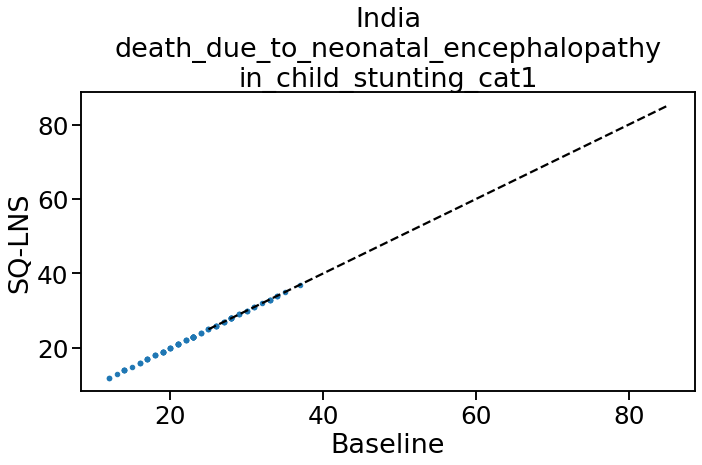

In [41]:
plt.plot(t.iloc[:,0], t.iloc[:,2], '.')
plt.plot([25,85], [25,85], 'k--')
plt.xlabel('Baseline')
plt.ylabel('SQ-LNS')
pretty_key = key.replace('_due_to_birth_asphyxia_and_trauma_', '\n')
plt.title(f"{country}\n{pretty_key}");

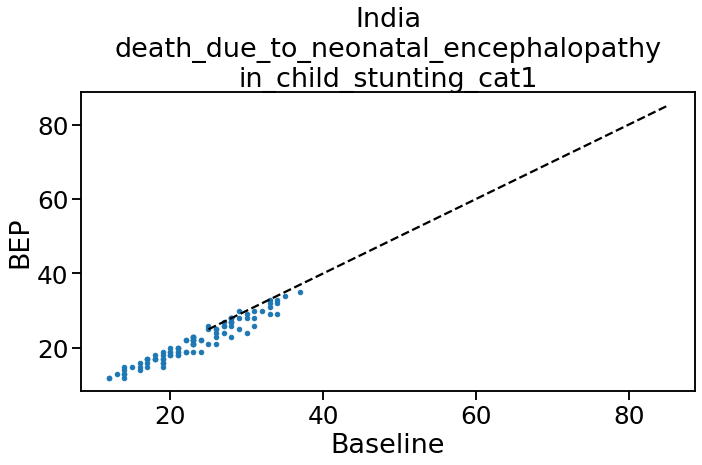

In [42]:
plt.plot(t.iloc[:,0], t.iloc[:,3], '.')
plt.plot([25,85], [25,85], 'k--')
plt.xlabel('Baseline')
plt.ylabel('BEP')
pretty_key = key.replace('_due_to_birth_asphyxia_and_trauma_', '\n')
plt.title(f"{country}\n{pretty_key}");

In [43]:
#MCVE
t = pd.read_hdf('vivarium_conic_sam_comparison_Pakistan/2019_09_12_14_36_44/output.hdf')

del t['random_seed']
scenarios = ['interventions.BEP_intervention.coverage_proportion',
 'interventions.SQ_LNS_intervention.coverage_proportion',
 'interventions.TF_SAM_intervention.coverage_proportion',]
g = t.reset_index().groupby(scenarios + ['input_draw_number', 'random_seed'])
t = g.first()
    
key = 'death_due_to_neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma_in_child_stunting_cat1'
t.loc[:,key].unstack().unstack().T

interventions.BEP_intervention.coverage_proportion      0.0              0.8
interventions.SQ_LNS_intervention.coverage_proportion   0.0         0.8  0.0
interventions.TF_SAM_intervention.coverage_proportion   0.0   0.8   0.0  0.0
random_seed input_draw_number                                               
0.0         8.0                                         5.0   5.0   5.0  4.0
            21.0                                        2.0   2.0   2.0  2.0
            29.0                                        3.0   3.0   3.0  3.0
            30.0                                        4.0   4.0   4.0  2.0
            36.0                                        9.0   9.0   9.0  9.0
...                                                     ...   ...   ...  ...
97.0        954.0                                       4.0   4.0   4.0  3.0
            956.0                                      10.0  10.0  10.0  8.0
            983.0                                       3.0   3.0   3.0  3.0
            990.0                                       3.0   3.0   3.0  3.0
            998.0                                       5.0   5.0   5.0  5.0

[1000 rows x 4 columns]

In [44]:
# missing some entries, but there are still jobs running
# what about India?

In [45]:
#MCVE
t = pd.read_hdf('vivarium_conic_sam_comparison_India/2019_09_12_14_36_19/output.hdf')

del t['random_seed']
scenarios = ['interventions.BEP_intervention.coverage_proportion',
 'interventions.SQ_LNS_intervention.coverage_proportion',
 'interventions.TF_SAM_intervention.coverage_proportion',]
g = t.reset_index().groupby(scenarios + ['input_draw_number', 'random_seed'])
t = g.first()
    
key = 'death_due_to_neonatal_encephalopathy_due_to_birth_asphyxia_and_trauma_in_child_stunting_cat1'
t.loc[:,key].unstack().unstack().T

interventions.BEP_intervention.coverage_proportion     0.0            0.8
interventions.SQ_LNS_intervention.coverage_proportion  0.0       0.8  0.0
interventions.TF_SAM_intervention.coverage_proportion  0.0  0.8  0.0  0.0
random_seed input_draw_number                                            
0.0         8.0                                        1.0  1.0  1.0  1.0
            21.0                                       2.0  2.0  2.0  2.0
            29.0                                       4.0  4.0  4.0  3.0
            30.0                                       1.0  1.0  1.0  1.0
            36.0                                       1.0  1.0  1.0  1.0
...                                                    ...  ...  ...  ...
97.0        954.0                                      7.0  7.0  7.0  6.0
            956.0                                      5.0  5.0  5.0  5.0
            983.0                                      0.0  0.0  0.0  0.0
            990.0                                      2.0  2.0  2.0  2.0
            998.0                                      4.0  4.0  4.0  4.0

[1000 rows x 4 columns]